In [2]:
from itertools import combinations
import numpy as np
from dataclasses import dataclass
from icecream import ic
import matplotlib.pyplot as plt

## Simple Test Problem

In [ ]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
test_problem = np.load('lab2/test_problem.npy')

## Common tests

In [ ]:
problem = np.load('lab2/problem_r1_10.npy')

In [ ]:
# Negative values?
np.any(problem < 0)

In [ ]:
# Diagonal is all zero?
np.allclose(np.diag(problem), 0.0)

In [ ]:
# Symmetric matrix?
np.allclose(problem, problem.T)

In [ ]:
# Triangular inequality
all(
    problem[x, y] <= problem[x, z] + problem[z, y]
    for x, y, z in list(combinations(range(problem.shape[0]), 3))
)

## Evolutionary Algorithm

In [ ]:
@dataclass
class Population:
    genotypes: np.ndarray 
    fitness: np.ndarray    

- fitness function

In [54]:
def fitness(sol: np.ndarray, problem: np.ndarray) -> np.float64:
    u = sol
    v = np.roll(sol, -1)
    total = problem[u, v].sum(dtype=np.float64)
    return np.float64(total)

def fitness_batch(pop: np.ndarray, problem: np.ndarray) -> np.ndarray:
    u = pop
    v = np.roll(pop, -1, axis=1)
    return problem[u, v].sum(axis=1, dtype=np.float64)

- mutation functions

ic| MAX_ITERS: 100000, best_cost: -4632.07261262998


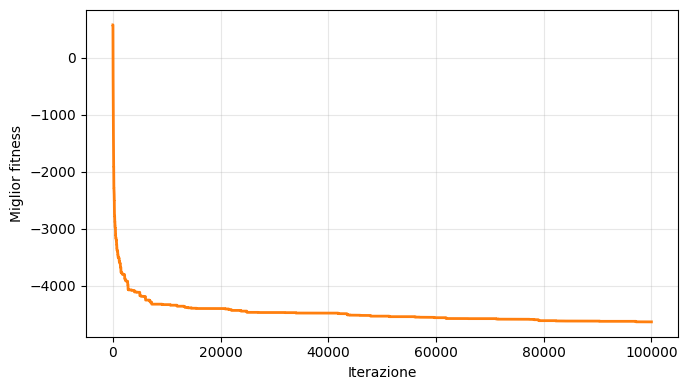

In [ ]:
def inversion(parent: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    # see slides 05 Searching for a State - EA, page 51

    rng = rng or np.random.default_rng()
    i, j = sorted(rng.choice(parent.size, size=2, replace=False))
    child = parent.copy()
    child[i:j] = child[i:j][::-1]
    return child

def insertion(parent: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    # see slides 05 Searching for a State - EA, page 50

    n = parent.size
    rng = rng or np.random.default_rng()
    i, j = rng.choice(n, size=2, replace=False)
    child = parent.tolist()
    gene = child.pop(i)
    child.insert(j, gene)
    return np.asarray(child, dtype=parent.dtype)

def swap(parent: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    # see slides 05 Searching for a State - EA, page 49

    rng = rng or np.random.default_rng()
    n = parent.size
    i, j = rng.choice(n, size=2, replace=False)
    child = parent.copy()
    child[i], child[j] = child[j], child[i]
    return child

def shuffle(p: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    # see slides 05 Searching for a State - EA, page 50
     
    n = p.size
    rng = rng or np.random.default_rng()
    i, j = sorted(rng.choice(n, size=2, replace=False))
    if j - i < 2:
        j = min(n, i + 2)
        i = max(0, j - 2)
    c = p.copy()
    c[i:j] = rng.permutation(c[i:j])
    return c


def three_opt(tour, rng):
    n = len(tour)
    i, j, k = sorted(rng.choice(n, size=3, replace=False))
    new_tour = np.concatenate([tour[:i], tour[j:k], tour[i:j], tour[k:]])
    return new_tour

# --- Hill Climbing semplice basato sulla mutazione scelta ---
rng = np.random.default_rng()
MAX_ITERS = 100000
problem = np.load('lab2/problem_r2_100.npy')
n = problem.shape[0]
cur = rng.permutation(n).astype(np.int32)          # soluzione iniziale casuale
cur_cost = float(fitness(cur, problem))            # usa la tua fitness
hc_history = [cur_cost]


for _ in range(MAX_ITERS):
    cand = three_opt(cur, rng=rng).astype(np.int32, copy=False)
    cand_cost = float(fitness(cand, problem))
    

    if cand_cost < cur_cost:                       # accetta solo miglioramenti
        cur, cur_cost = cand, cand_cost
   

    hc_history.append(cur_cost)

best_route = cur
best_cost = cur_cost
ic(MAX_ITERS, best_cost)

x = np.arange(1, len(hc_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, hc_history, color='tab:orange', lw=2)
plt.xlabel('Iterazione')
plt.ylabel('Miglior fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# ...existing code...

In [ ]:
hc_history[80000]

- ricombination function

In [ ]:
def pmx(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:

    n = p1.shape[0]
    rng = rng or np.random.default_rng()

    i, j = sorted(rng.choice(n, size=2, replace=False))

    c = np.full(n, -1, dtype=p1.dtype)

    c[i:j] = p1[i:j]

    seg1 = p1[i:j]
    seg2 = p2[i:j]
    set_seg1 = set(seg1.tolist())

    map12 = {a: b for a, b in zip(seg1, seg2)}

    for idx in list(range(0, i)) + list(range(j, n)):
        g = p2[idx]
        while g in set_seg1:
            g = map12[g]
        c[idx] = g

    return c

def cycle_crossover(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    
    rng = rng or np.random.default_rng()
    n = p1.shape[0]
    i, j = sorted(rng.choice(n, size=2, replace=False))


    c = np.full(n, -1, dtype=p1.dtype)
    c[i:j] = p1[i:j]


    used = np.zeros(n, dtype=bool)
    used[p1[i:j]] = True

    pos_out = np.r_[np.arange(0, i), np.arange(j, n)]
    fill = p2[~used[p2]][:pos_out.size]

    c[pos_out] = fill
    return c

def uniform_crossover(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    
    rng = rng or np.random.default_rng()
    n = p1.size
    c = np.full(n, -1, dtype=p1.dtype)
    used = np.zeros(n, dtype=bool)  

    for i in range(n):
        a, b = int(p1[i]), int(p2[i])

        if a == b and not used[a]:
            c[i] = a
            used[a] = True
            continue

        if used[a] and not used[b]:
            c[i] = b
            used[b] = True
            continue
        if used[b] and not used[a]:
            c[i] = a
            used[a] = True
            continue

        if not used[a] and not used[b]:
            pick = a if rng.random() < 0.5 else b
            c[i] = pick
            used[pick] = True
            continue

        remaining = np.flatnonzero(~used)
        val = int(remaining[rng.integers(remaining.size)])
        c[i] = val
        used[val] = True

    return c.astype(np.int32, copy=False)

def inver_over(parent1, parent2, rng):
    n = len(parent1)
    child = parent1.copy()
    i = rng.integers(n) 
    city_a = child[i]
    city_b = parent2[(np.where(parent2 == city_a)[0][0] + 1) % n]
    

    j = np.where(child == city_b)[0][0]
    
    if i < j:
        child[i+1:j+1] = child[i+1:j+1][::-1]
    else:
        child[j+1:i+1] = child[j+1:i+1][::-1]
    return child


array([ 9,  1,  2,  3,  4,  5,  6,  7, 10,  0,  8])

- parent selection

In [8]:
def tournament(fitness: np.ndarray, k: int = 3, rng: np.random.Generator | None = None) -> int:
    rng = rng or np.random.default_rng()
    k = min(k, fitness.shape[0])
    idx = rng.choice(fitness.shape[0], size=k, replace=False)
    return idx[np.argmin(fitness[idx])]  


In [ ]:

def tsp_solver(problem: np.ndarray, mutation, ricombination, parent_selection) -> tuple[np.ndarray, float, list[float]]:


    PROBLEM_SIZE = problem.shape[0]
    rng = np.random.default_rng()

    
    genotypes = np.vstack([rng.permutation(PROBLEM_SIZE) for _ in range(POPULATION_SIZE)]).astype(np.int32)
    fitnesses = fitness_batch(genotypes, problem)
    current_population = Population(genotypes=genotypes, fitness=fitnesses)

    best_fitness = float('inf')
    best_genotype = None
    best_history: list[float] = []
    
    for _gen in range(1, MAX_GENERATIONS + 1):
        
        offspring_genotypes = np.empty((OFFSPRING_SIZE, PROBLEM_SIZE), dtype=np.int32)
        
        for o in range(OFFSPRING_SIZE):
            if rng.random() < MUTATION_RATE:
                p = parent_selection(current_population.fitness, k=3, rng=rng)
                child = mutation(current_population.genotypes[p], rng=rng)
            else:
                p1 = parent_selection(current_population.fitness, k=3, rng=rng)
                p2 = parent_selection(current_population.fitness, k=3, rng=rng)
                while p2 == p1:
                    p2 = parent_selection(current_population.fitness, k=3, rng=rng)
                child = ricombination(current_population.genotypes[p1], current_population.genotypes[p2], rng=rng)
            offspring_genotypes[o, :] = child
        
    
        offspring_fitness = fitness_batch(offspring_genotypes, problem)

        all_genotypes = np.vstack([current_population.genotypes, offspring_genotypes])
        all_fitness = np.concatenate([current_population.fitness, offspring_fitness])
        order = np.argsort(all_fitness)
        current_population = Population(
            genotypes=all_genotypes[order][:POPULATION_SIZE],
            fitness=all_fitness[order][:POPULATION_SIZE],
        )

        if current_population.fitness[0] < best_fitness:
            best_fitness = current_population.fitness[0]
            best_genotype = current_population.genotypes[0]
        best_history.append(float(current_population.fitness[0]))

    return (best_genotype, best_fitness, best_history)


ic| best_fitness: np.float64(1497.6636482252907)
    best_genotype: array([3, 1, 6, 4, 5, 9, 7, 0, 8, 2], dtype=int32)


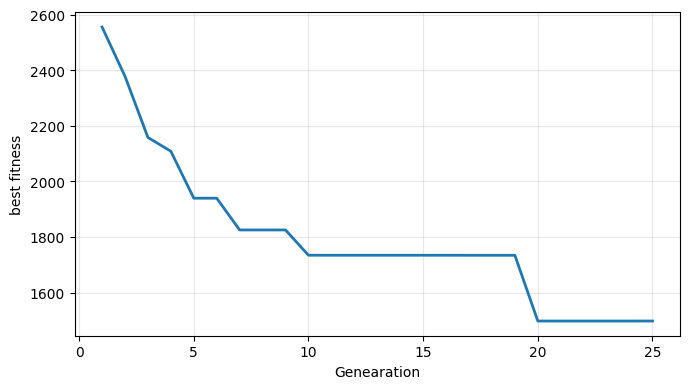

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 25

problem = np.load('lab2/problem_g_10.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(1755.5146770830047)
    best_genotype: array([14, 19, 15,  3,  8,  6, 13, 11,  0,  5, 18, 10,  4, 17,  2,  9, 12,
                           7,  1, 16], dtype=int32)


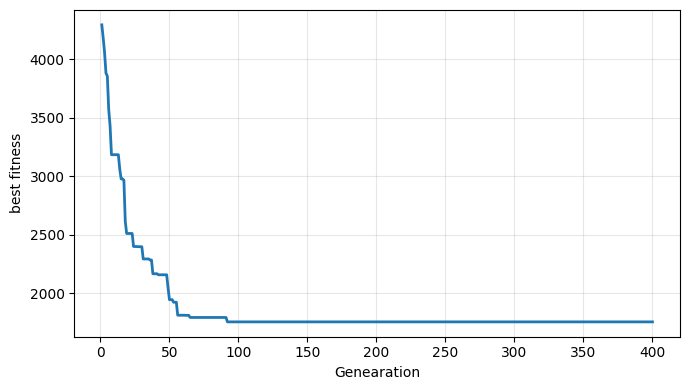

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 400

problem = np.load('lab2/problem_g_20.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(2770.5678761772415)
    best_genotype: array([ 7,  6, 44, 45, 16, 35, 13, 15, 28, 12, 36,  1, 41, 33, 21, 37, 39,
                          26, 17,  8, 38, 49, 48, 40, 18, 46, 20, 31, 24, 42, 32, 29, 19,  9,
                           2,  4, 11,  3, 10, 34, 22, 43, 47, 14, 25,  5, 30, 23, 27,  0],
                         dtype=int32)


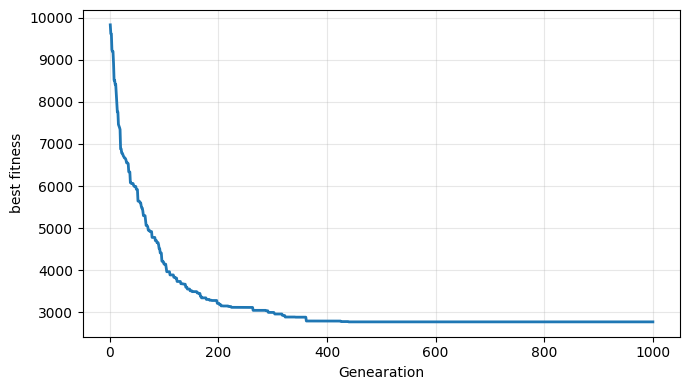

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 1000

problem = np.load('lab2/problem_g_50.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(4291.194756004843)
    best_genotype: array([68, 52, 83, 89, 85, 69, 22,  5, 49,  1,  8, 36, 46, 93, 55,  4, 75,
                          34, 86, 87, 43, 92, 88, 78, 12, 91,  6, 77, 50, 15, 24, 40, 19, 80,
                          25, 26, 13, 96, 98, 39, 65, 76, 29, 59, 82,  9, 23, 61, 62, 90, 38,
                          95, 35, 17, 44, 94, 79, 66, 84,  3, 51, 28, 21, 60, 11,  2, 58, 73,
                          45, 53, 16, 31, 72, 18, 56, 70, 57, 41, 14, 74, 71, 47, 63, 27, 20,
                          99,  7, 37,  0, 33, 54, 67, 32, 48, 10, 42, 64, 97, 30, 81],
                         dtype=int32)


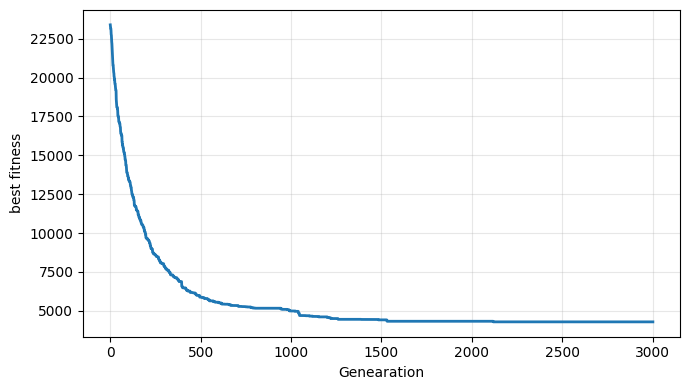

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 3000

problem = np.load('lab2/problem_g_100.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(6165.9038874734615)
    best_genotype: array([ 39, 130,  80,  21, 157,  82, 196, 184, 126, 116, 123,  62,  42,
                           97,  51, 100, 140,  71,  57,  74, 131, 156, 146, 143,   1, 111,
                           78,  53, 155, 133,  17, 176,  52,  10, 132,  56,  77, 185, 181,
                          124,  40, 171,  41, 117, 144,  86,  59, 197,  85, 199, 173,  48,
                          107, 115, 148, 160, 154, 119, 175,   2, 151,  25,  92,  38,   9,
                           98, 167, 186,  67,  24,   6,  46,  30,  11, 139, 136, 178, 138,
                           99,  76,  66, 106, 128, 172, 193,  64, 165,  27,   7, 142, 102,
                          170, 112, 125,  19, 110,  33,  81,  88, 122,  34,   3,  75,  65,
                          114, 127, 162,  55,  45,  49,  35,  94, 108, 152,  12,  84, 192,
                          164, 195, 191, 129,  61, 180, 159, 153,  83,  16, 137,  37, 169,
                            8,   0,  60, 

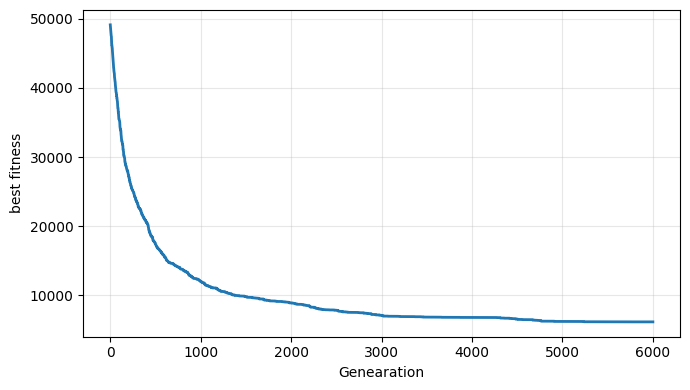

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 6000


problem = np.load('lab2/problem_g_200.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(9485.38109673305)
    best_genotype: array([ 30,  66, 406, 227, 355, 420, 413,  10, 499, 264, 404, 400, 193,
                          106, 223, 421, 376, 463, 197, 159, 291, 325, 461,  88, 473, 427,
                          128, 336,  42, 269, 212, 444, 125,  89,  32, 294, 243, 326,  33,
                          319, 364, 152, 375,  23, 151, 343, 496, 258, 242, 173, 338, 220,
                          451, 157, 419,  41, 124, 234, 405,   7, 251, 118, 138, 394, 266,
                          452, 475, 293, 367, 179, 213, 453, 164, 381, 348, 218, 354, 471,
                          322, 440, 388, 252, 204, 497, 371, 437, 484,  82, 391, 331, 149,
                          292, 422, 103, 485, 100,  50, 478, 448, 263,  16,  11, 216, 289,
                          175, 465, 399,  34, 280, 389, 245,  83,  51, 237, 309, 464,  76,
                          317, 392, 229, 434, 442,   6, 130,   5,  67, 386, 146, 268, 132,
                          168, 288,  68, 37

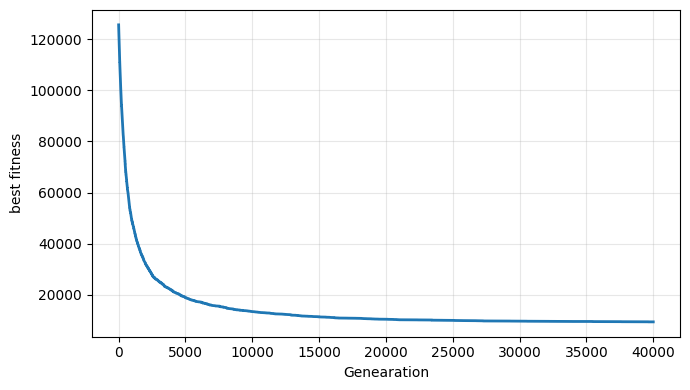

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 40000

problem = np.load('lab2/problem_g_500.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(14250.196612816797)
    best_genotype: array([564, 271, 191, 935, 142, 840, 327, 232, 481, 755, 520, 681, 969,
                          488, 778, 343, 387, 199, 618, 132, 949, 365, 608, 685, 116, 272,
                          506, 884, 939, 613, 815, 823, 602, 503,  63, 354, 826, 963, 455,
                          254, 317, 910, 736, 179, 115, 108, 814, 591, 201, 559, 322, 955,
                          957,  31, 449, 276, 626, 384, 906, 552, 651, 687, 496, 836,  22,
                          395, 628, 549, 698, 748, 323, 812, 945, 551,  85, 731, 765,  26,
                          605, 461,  39, 975,  93, 756, 974, 237, 527, 585,  43, 796, 926,
                          143, 785, 198, 368, 809, 206, 500, 759, 656,  94, 246, 807, 696,
                          136,  51, 810, 638, 783, 567, 242, 418, 178, 977, 557, 149, 998,
                          704, 168, 880,  60, 749, 919, 171, 804, 943, 530, 388, 673, 111,
                          954, 931, 432, 

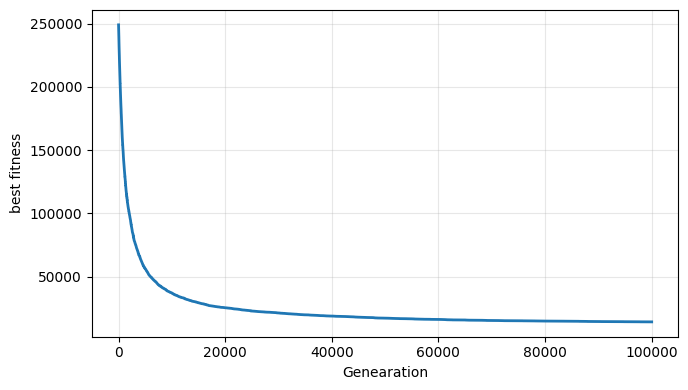

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 100000

problem = np.load('lab2/problem_g_1000.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(184.27344079993898)
    best_genotype: array([8, 0, 4, 5, 3, 6, 2, 9, 7, 1], dtype=int32)


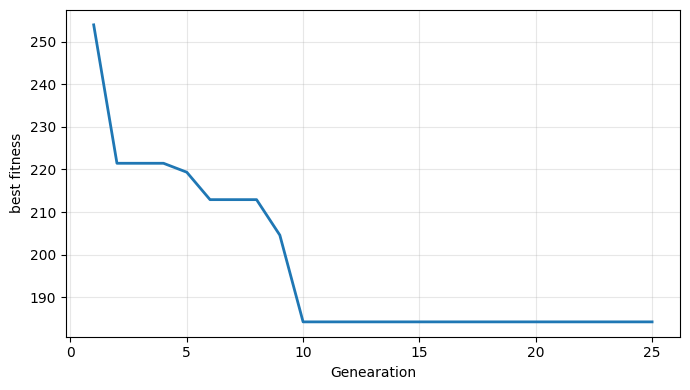

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 25

problem = np.load('lab2/problem_r1_10.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(343.7591968520694)
    best_genotype: array([12,  4,  1,  3, 19,  2,  0, 18, 14, 11,  6,  8, 10,  5, 13, 17, 15,
                           7, 16,  9], dtype=int32)


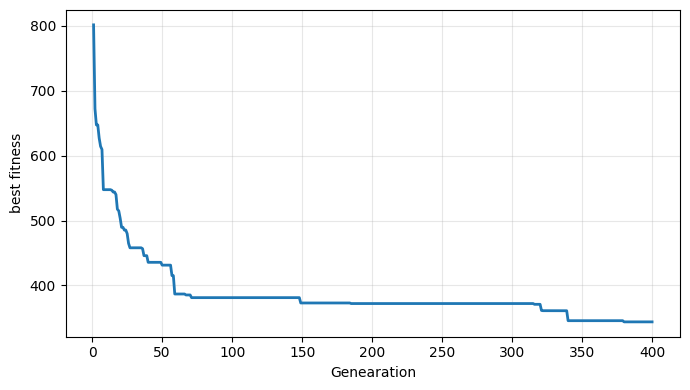

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 400

problem = np.load('lab2/problem_r1_20.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(574.673043416118)
    best_genotype: array([ 8, 26, 21, 46, 49,  7,  3, 27,  0, 15, 13, 16, 29,  5,  1, 17, 12,
                          40, 35, 38, 43, 32, 36, 22, 39, 10, 33, 11, 44, 37,  2, 24, 14, 23,
                          34, 42, 31, 48, 18, 41, 25,  4, 19, 47, 28, 45,  9,  6, 30, 20],
                         dtype=int32)


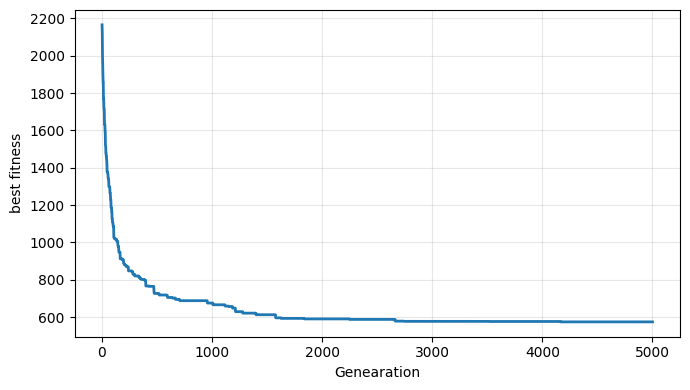

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 5000

problem = np.load('lab2/problem_r1_50.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(786.2662026144661)
    best_genotype: array([83, 74, 93, 95, 69, 86, 40, 30, 37, 60, 73,  2, 96, 14, 64, 98, 16,
                          32, 72, 91, 42,  0,  1, 92, 76, 59, 61,  9, 63, 33,  6, 67, 39,  3,
                          66, 31, 49, 38, 54, 18, 82, 97, 27,  7, 89, 44, 21, 34, 88, 15, 10,
                          62, 28, 68, 79, 11, 50, 81, 35, 29, 52,  8, 99, 46, 26, 55, 77, 65,
                          41, 25, 78, 43, 17, 84, 70, 56, 71, 85, 13, 75,  4, 53, 94, 80, 51,
                          36,  5, 22, 58, 12, 24, 57, 45, 48, 90, 19, 23, 47, 87, 20],
                         dtype=int32)


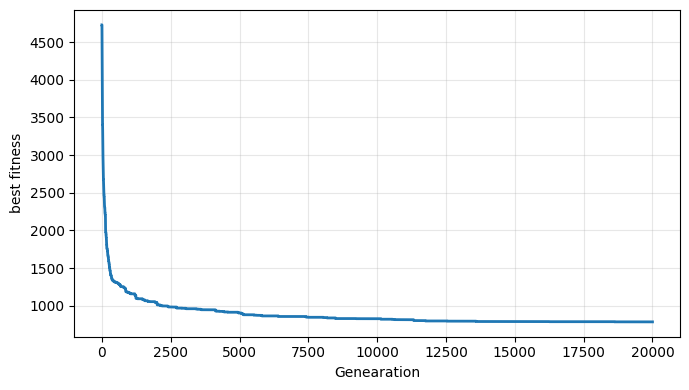

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 20000

problem = np.load('lab2/problem_r1_100.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(1199.6330723574176)
    best_genotype: array([118,  48,  95,  19,  78, 187,   4, 199,  73,   5,  66,  55,  75,
                          169, 179, 183,  41,  77,  46, 101, 103,  71,  65,  25, 156,  49,
                           47,  97,  30,  51,  43,  50,  13, 110,   9,  36,  67, 195, 154,
                           12, 198,  74,  16, 189, 130,  99, 144, 141,  79,  53, 124, 147,
                           56, 136,  39, 175, 159, 145,  84, 164,  80,   0, 108,  86,  52,
                          139,  34, 100, 160, 148, 134, 157, 102,  23,  28, 180,  69, 128,
                          114,  83, 177, 186, 119, 116,   7, 170,   8,  82,   2,  38, 151,
                           42, 172, 163,  21, 121, 155, 109, 133, 182, 190, 176,  35,  96,
                          194,  26,  44,  88, 181,  85, 168,  40, 178,  60, 191, 150, 123,
                          125, 135, 173, 138, 122,   1, 196,  18, 112,  61,  91, 111,  81,
                           27,  11, 171, 

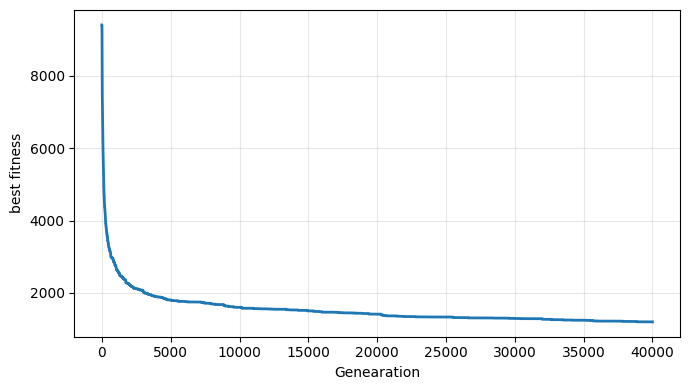

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 40000

problem = np.load('lab2/problem_r1_200.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(2820.247426615651)
    best_genotype: array([ 89, 257,  23, 208, 301, 366, 121, 359, 353,  92, 443, 363, 171,
                          123, 295,   2, 217, 106, 163, 325,  90, 197, 451, 238, 484, 176,
                           99, 207, 177, 120,  87,  28, 131, 275, 376, 290, 222,  41,  36,
                          393, 136,  84,  67, 200, 405, 285, 467, 160,  45,  58, 236, 227,
                           46, 335, 189, 126, 203, 185, 138, 346,  29, 307, 379, 174,   0,
                          486, 149, 341, 387,  11, 391, 287, 239,  38, 332, 110, 415, 214,
                          298, 153, 390, 349,  98, 270, 267, 360, 445, 219, 242, 345, 339,
                          410, 144,  77, 483,  53,  27, 105, 281,  24, 406,  20, 117,  78,
                          233, 245, 146, 426, 292, 173, 471,   5, 494, 317, 147, 384, 118,
                          323, 413,  71, 365, 496, 320, 309, 388, 331,  31, 399,  42,   7,
                          420, 164,  95, 2

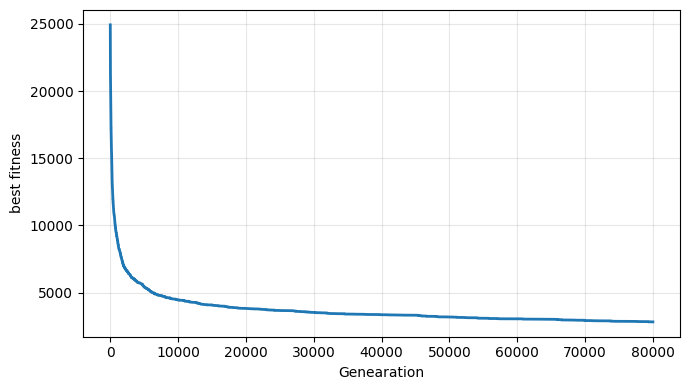

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 80000

problem = np.load('lab2/problem_r1_500.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)

x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(6161.039796471197)
    best_genotype: array([434, 385, 504, 171, 889, 778, 481, 755, 460, 281, 130, 944, 782,
                          942, 989, 441, 359, 108, 763, 816, 400, 595, 533, 792, 544, 937,
                          339, 257, 670, 635, 981, 768, 132, 401,  64,  90, 279, 952, 941,
                          333, 370, 591, 259, 358, 241, 784, 912,  58, 598,  67, 467, 440,
                          534, 735,  95, 417, 372, 604, 767, 926, 886, 776, 369, 616, 653,
                          513, 473, 338, 411, 197, 836, 425, 282, 310, 658, 390,  81,  44,
                          958,   7, 611, 619, 563, 588, 548, 406, 741, 433, 602, 530, 721,
                          469, 351,  92, 387, 263,  10, 629, 137, 846, 200, 317, 133, 258,
                          740, 539, 399, 852, 664, 510,  83, 756, 187, 982, 210, 330, 256,
                          218, 427, 684, 807, 391, 825, 774, 160, 751, 198, 248, 817, 442,
                          993,   3, 880, 7

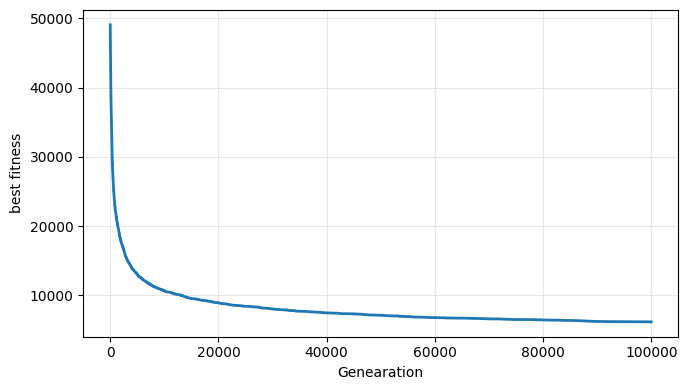

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 100000

problem = np.load('lab2/problem_r1_1000.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)

x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-411.70171555249846)
    best_genotype: array([7, 6, 3, 4, 8, 1, 9, 5, 0, 2], dtype=int32)


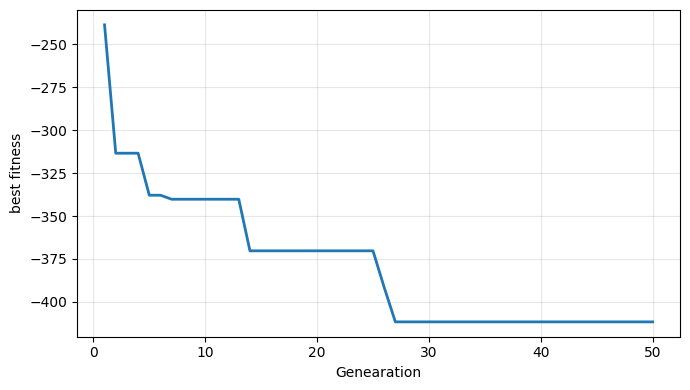

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 50

problem = np.load('lab2/problem_r2_10.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)

x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-861.6672062881739)
    best_genotype: array([ 3,  5,  7, 11, 17, 13, 10, 14, 12,  9, 15, 16,  2,  6, 18,  8,  0,
                          19,  4,  1], dtype=int32)


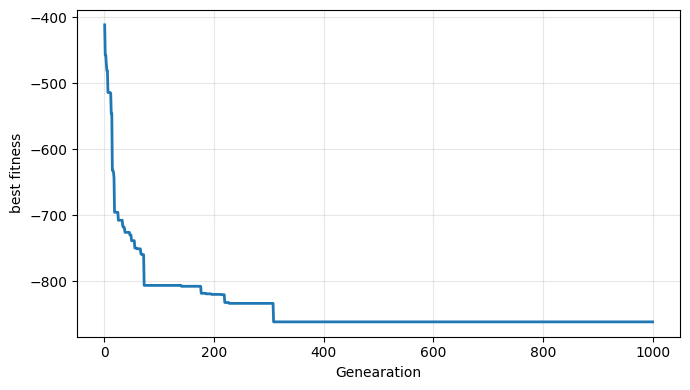

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 1000

problem = np.load('lab2/problem_r2_20.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-2285.219602098752)
    best_genotype: array([45, 30, 23,  4, 25,  5, 14, 47, 10, 13, 37,  8, 33, 34, 31, 40, 44,
                          19, 18, 43, 22,  2, 35, 16, 38,  7, 46, 42, 11, 32, 36, 49, 48,  3,
                          39, 28, 20, 27, 12,  0,  6, 29,  9, 15, 21, 24, 41, 17, 26,  1],
                         dtype=int32)


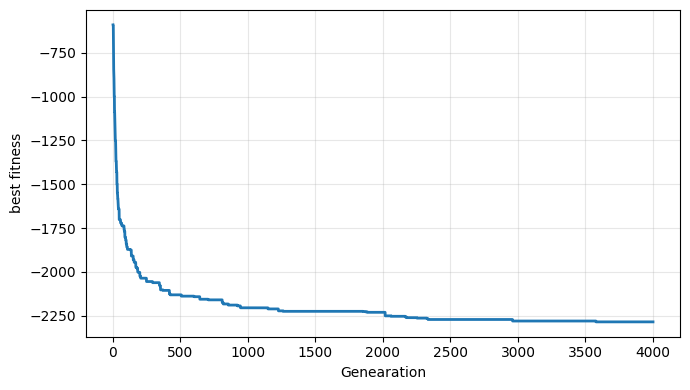

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 4000

problem = np.load('lab2/problem_r2_50.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-4643.648797212908)
    best_genotype: array([17, 19, 67, 55, 96, 76, 56, 22, 54, 42, 86, 74, 20,  5, 57, 59, 88,
                          95, 10, 23,  6,  9, 62, 94, 73, 47, 77, 27, 64, 72, 98, 70, 82, 61,
                          40, 65, 51, 48, 81, 60,  8, 85, 84,  4, 75, 66, 71, 14, 36, 11, 45,
                          68, 26, 97, 25, 33, 49, 99,  7, 63, 35, 58, 38,  2, 41,  0, 29,  1,
                          24, 79, 18, 30, 90, 28, 92, 44, 16, 87, 50, 31, 91, 12, 53, 89, 46,
                          69, 43, 32, 15, 21, 83, 39, 93, 37, 78, 80, 52, 34,  3, 13],
                         dtype=int32)


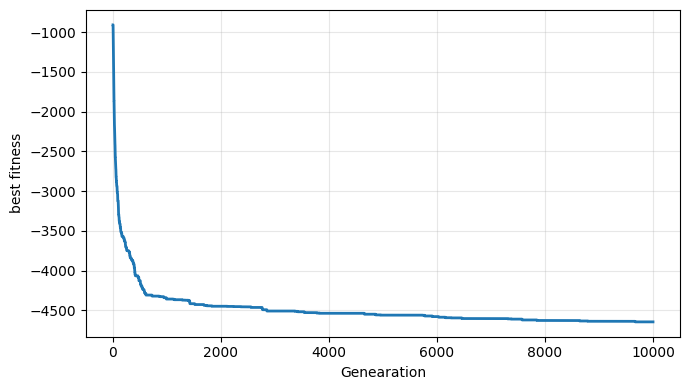

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 10000

problem = np.load('lab2/problem_r2_100.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-9343.842706559466)
    best_genotype: array([143,  96,  45, 199, 101, 135, 189, 116,  21,  48,  71,  33,  52,
                           56,  40, 158,  46, 169, 126, 167,  27, 123,  94, 197,  81,  58,
                           55, 118,   5, 152, 176,  67,  16,  86, 112,  37, 172,  80, 150,
                           59,  29,  43,  51,  78, 164,  82,  10,  17, 131,  85, 136, 179,
                          192,  84, 173,  88,  92,  60,   6,   0, 151, 190, 128, 156, 188,
                           49, 124, 174, 138, 104, 166, 127,  74,  14,  61,  95,  99,  18,
                           93, 162,  69, 111,  41, 110, 120, 108,  90, 181, 147,  68,  13,
                           31,  91, 157, 133, 163, 134,  97, 105,  15, 170,   3, 114, 142,
                           34, 129,  22, 145,  42, 121,  98, 194, 187,  50, 185,  73,   8,
                           32, 155,  25, 139,   4, 146, 198, 103,  70,  36, 130, 184, 186,
                           28,  76, 107, 

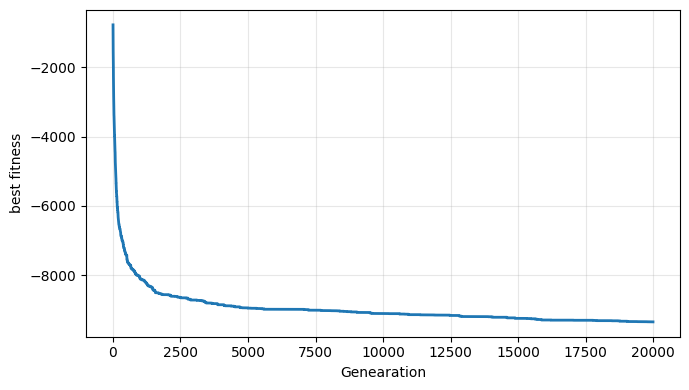

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 20000

problem = np.load('lab2/problem_r2_200.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-23326.265209121026)
    best_genotype: array([102, 213, 392, 373, 194, 335,  48, 263,  83, 482, 104, 110, 170,
                          360, 271, 395,  69,  87, 363, 398, 258, 322, 260,  39,  93, 473,
                          387,  51, 234, 111, 433, 440, 290, 282, 103, 136, 236, 424, 376,
                          370, 477,  88, 164, 286, 137, 346, 491,  99, 281,  65, 177, 439,
                          304, 148, 459, 181,  62, 279, 446, 347, 342, 397,  76,   2, 121,
                          422, 117, 469, 197, 324,  52, 224, 266, 451, 191,   5,  95, 319,
                          130, 407, 297, 202, 463, 306, 379, 101, 239, 165,  78, 207, 412,
                          442, 199, 228, 495,  54, 365, 429,  67, 355, 388, 244, 287, 353,
                          160,  14, 283, 292, 152, 499, 166, 453, 341,   3, 184, 351, 284,
                          425, 119,  32,  75, 251, 443,  46, 487, 307, 396,  15, 298, 240,
                          192,  29, 274,

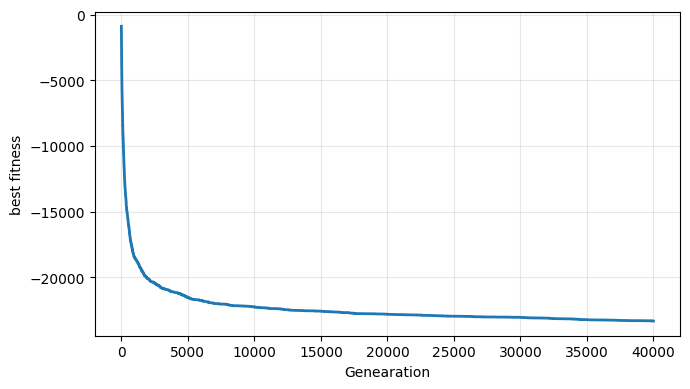

In [ ]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 40000

problem = np.load('lab2/problem_r2_500.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-46755.88124750078)
    best_genotype: array([764, 426, 186, 991,  73, 926, 681, 415, 301, 579, 508, 624, 584,
                          891, 662, 695, 155, 326, 896, 682, 106, 877, 195, 850, 629, 825,
                          633, 157, 934, 588, 481, 257,  87, 293, 185, 719, 192, 117, 611,
                          388, 153, 414, 346, 861, 994, 669, 635, 216, 796, 818, 116, 880,
                           40, 720,  52, 770, 909, 167, 545, 722, 958, 491, 959, 598, 240,
                          227, 328, 323, 664, 813, 252, 832, 266, 276, 728, 194,  27, 805,
                          428, 365, 714,  54, 225, 936, 304, 748, 897,  77, 187,  70, 931,
                          566, 574, 680, 250, 198, 733,  58, 752, 982, 917, 460, 310,  15,
                          364, 125, 123, 986, 563, 524, 513, 436, 947, 661, 849, 118, 502,
                           49, 202, 557, 837, 407,  42, 826, 553, 238, 527, 914, 248, 309,
                          325, 839, 151, 

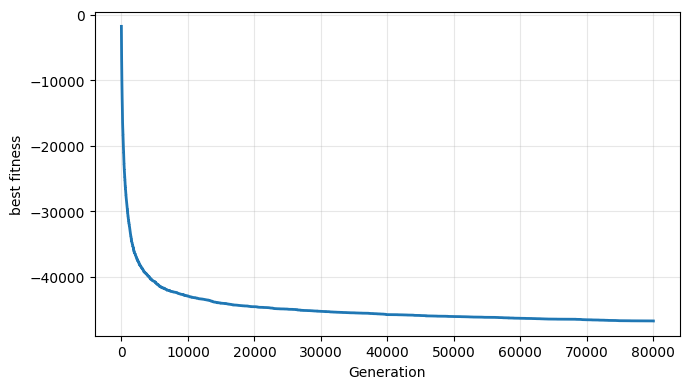

In [51]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 80000

problem = np.load('lab2/problem_r2_1000.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()